In [1]:
import pyart
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import cartopy.crs as ccrs
from pyproj import Proj, CRS, Transformer
import glob
import xarray as xr
from datetime import datetime, timedelta
import pandas as pd
from scipy.interpolate import griddata
from collections import defaultdict


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Date of the data
year = '2025'
month = '03'
day = '13'

# The path to the data directory
# The data is stored in the following directory structure
# /mnt/gws/data/tone-ico_doppler_scanning_cloud_radar/L0/Y2025/M03/D13/
# The year, month and day are used to construct the path
data='/gws/nopw/j04/tone_ico_gws/data/tone-ico_doppler_scanning_cloud_radar/L0/Y'+year+'/M'+month+'/D'+day+'/*PPI.LV1.NC'
file_list = sorted(glob.glob(data))  

In [3]:
# === Buffers for accumulation ===
accum_buffers = defaultdict(lambda: defaultdict(list))  # accum_buffers[hour][(i,j)] = [(time, rate)]

In [4]:
# Takes in the raw data and a target grid, extracts reflectivity and regrids to the target grid
def extract_and_interpolate_fields(ds, lat_target, lon_target):
    # === Extract reflectivity ===
    cze_vars = ['C1ZE45', 'C2ZE45', 'C3ZE45', 'C4ZE45']
    range_vars = [var.replace('ZE45', 'Range') for var in cze_vars]
    data_list = [ds[var].values for var in cze_vars]
    range_list = [ds[var].values for var in range_vars]

    # Stack reflectivity and range
    data_stacked = np.concatenate(data_list, axis=1)  # (n_az, total_range)
    ranges_stacked = np.concatenate(range_list)       # (total_range,)

    # Filter low reflectivity
    data_stacked[data_stacked < -30] = np.nan

    # === Get azimuths ===
    n_az = data_stacked.shape[0]
    azimuths = np.linspace(0, 2 * np.pi, n_az, endpoint=False)

    azimuths_2d, ranges_2d = np.meshgrid(azimuths, ranges_stacked, indexing='ij')
    X = ranges_2d * np.cos(azimuths_2d)
    Y = ranges_2d * np.sin(azimuths_2d)

    # === Polar to lat/lon ===
    trollLat = ds['GPSLat'].values.item()
    trollLon = ds['GPSLon'].values.item()
    crs_centered = CRS.from_proj4(f"+proj=aeqd +lat_0={trollLat} +lon_0={trollLon} +datum=WGS84 +units=m +no_defs")
    crs_geo = CRS.from_epsg(4326)
    transformer = Transformer.from_crs(crs_centered, crs_geo, always_xy=True)
    lon, lat = transformer.transform(X, Y)

    # === Interpolate reflectivity onto target grid ===
    points = np.column_stack((lat.ravel(), lon.ravel()))
    values = data_stacked.ravel()
    dbz_interp = griddata(points, values, (lat_target, lon_target), method='linear', fill_value=np.nan)

    # === Interpolate time onto target grid ===
    # Time is in seconds since 2001-01-01 00:00:00
    time_array = ds['Time'].values.astype(float)  # shape: (n_az,)
    base = np.datetime64('2001-01-01T00:00:00', 's')

    # Convert to datetime and then seconds since midnight
    absolute_times = base + time_array.astype('timedelta64[s]')
    seconds_since_midnight = (absolute_times - absolute_times.astype('datetime64[D]')).astype('timedelta64[s]').astype(float)

    # Expand time to match (n_az, n_range)
    time_2d = np.repeat(seconds_since_midnight[:, np.newaxis], data_stacked.shape[1], axis=1)

    # Interpolate time field onto the same target grid
    time_values = time_2d.ravel()
    time_interp = griddata(points, time_values, (lat_target, lon_target), method='linear', fill_value=np.nan)

    return dbz_interp, time_interp

In [5]:
# converts dbz to snowfall rate - ADJUST A, B (Souverijns et al. 2017) as needed
def reflectivity_to_snowfall_rate(dbz, a, b):
    dbz[dbz > 1000] = np.nan
    z = 10 ** (dbz / 10)

    rate = (z / a) ** (1 / b)
    return rate

In [6]:
# adding in new (time, snowfall rate) coordinate tuples to the buffer
def update_accumulation_buffer(precip_grid, time_grid):
    for i in range(precip_grid.shape[0]):
        for j in range(precip_grid.shape[1]):
            rate = precip_grid[i, j]
            time = time_grid[i, j]
            if np.isnan(rate) or np.isnan(time):
                continue
            hour = int(time // 3600)
            accum_buffers[hour][(i, j)].append((time, rate))

In [7]:
def compute_hourly_accumulation(accum_buffers, grid_shape):
    """
    Compute hourly snow accumulation from accum_buffers.

    Parameters:
    - accum_buffers: dict of {hour: {(i,j): [(time, rate), ...], ...}, ...}
    - grid_shape: tuple (ny, nx) shape of the target grid

    Returns:
    - dict of {hour: 2D numpy array (ny, nx) of accumulated snow in mm}
    """

    hourly_accum = {}

    for hour, pixel_data in accum_buffers.items():
        # Initialize accumulation array with NaNs
        accum_array = np.full(grid_shape, np.nan, dtype=float)

        for (i, j), time_rate_list in pixel_data.items():
            if len(time_rate_list) < 2:
                # Not enough points to integrate
                continue

            # Extract times and rates, sort by time
            sorted_pairs = sorted(time_rate_list, key=lambda x: x[0])
            times = np.array([pair[0] for pair in sorted_pairs])      # seconds
            rates = np.array([pair[1] for pair in sorted_pairs])      # mm/hr

            # Convert time to hours for integration
            times_hours = times / 3600.0

            # Trapezoidal integration to get accumulation in mm
            accum = np.trapz(rates, times_hours)

            accum_array[i, j] = accum

        hourly_accum[hour] = accum_array

    return hourly_accum

In [8]:
# generating the target uniform lat/lon grid
lat_grid = np.arange(-72.15, -71.85, 0.001)
lon_grid = np.arange(2, 3, 0.001)
lon_target, lat_target = np.meshgrid(lon_grid, lat_grid)


# iterating over all the hourly radar scans during the given day, and storing in a common data structure on a common grid
for file in file_list[:]:
    ds = xr.open_dataset(file)

    # Step 1: Extract reflectivity and time, interpolate to lat/lon
    dbz_interp, time_interp = extract_and_interpolate_fields(ds, lat_target, lon_target)

    a = 18
    b = 1.1

    # Step 2: Convert to snowfall rate
    snowfall_rate = reflectivity_to_snowfall_rate(dbz_interp, a, b)

    # Step 3: Update the accumulation buffer with new data
    update_accumulation_buffer(snowfall_rate, time_interp)



In [9]:
# lat_grid and lon_grid are 1D arrays
grid_shape = (len(lat_grid), len(lon_grid))  # (ny, nx)

hourly_accumulation = compute_hourly_accumulation(accum_buffers, grid_shape)

# Example: print mean accumulation for each hour
for hour, accum_field in sorted(hourly_accumulation.items()):
    print(f"Hour {hour}: mean accumulation = {np.nanmean(accum_field):.2f} mm")

Hour 0: mean accumulation = 0.04 mm
Hour 1: mean accumulation = 0.04 mm
Hour 2: mean accumulation = 0.05 mm
Hour 3: mean accumulation = 0.05 mm
Hour 4: mean accumulation = 0.05 mm
Hour 5: mean accumulation = 0.05 mm
Hour 6: mean accumulation = 0.05 mm
Hour 7: mean accumulation = 0.05 mm
Hour 8: mean accumulation = 0.05 mm
Hour 9: mean accumulation = 0.04 mm
Hour 10: mean accumulation = 0.05 mm
Hour 11: mean accumulation = 0.05 mm
Hour 12: mean accumulation = 0.08 mm
Hour 13: mean accumulation = 0.06 mm
Hour 14: mean accumulation = 0.06 mm
Hour 15: mean accumulation = 0.06 mm
Hour 16: mean accumulation = 0.05 mm
Hour 17: mean accumulation = 0.04 mm
Hour 18: mean accumulation = 0.06 mm
Hour 19: mean accumulation = 0.09 mm
Hour 20: mean accumulation = 1.06 mm
Hour 21: mean accumulation = 9322.87 mm
Hour 22: mean accumulation = 2572267.97 mm
Hour 23: mean accumulation = 1232315.77 mm


In [10]:
print(hourly_accumulation)

{0: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(301, 1000)), 1: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(301, 1000)), 2: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(301, 1000)), 3: array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [

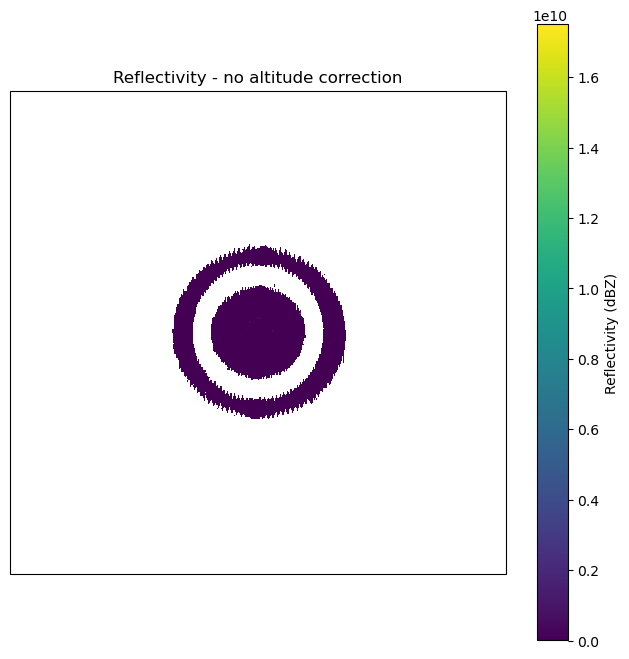

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())

trollLon = 2.54
trollLat = -72.01

ax.set_extent([trollLon-0.5, trollLon+0.5, trollLat-0.15, trollLat+0.15], crs=ccrs.PlateCarree())
ax.coastlines()

cf = ax.pcolormesh(lon_grid, lat_grid, hourly_accumulation[22], transform=ccrs.PlateCarree(), cmap='viridis')
plt.colorbar(cf, label='Reflectivity (dBZ)')
plt.title("Reflectivity - no altitude correction")

plt.show()

In [12]:
# NEW DATA STRUCTURE:
# A 2d array (lat x lon), where each element is a list of tuples. The tuples are 2d coordinates, timestamp as x and snowfall rate as y.